This notebook reposition the sphere and receiver positions to give a more rigorous proof 

In [1]:
!pip install nptyping==1.0.1
!pip install SciencePlots
!pip install Theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=6d679a7de3d04d4aab17903d8704908166f44f1ab287d752b0f2321647008e7d
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 6.6 MB/s 
  Created wheel for Theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=ca1ba12d3ee46342716ed55b7389bb8869

In [2]:
import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

# import matplotlib
# from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
from functools import reduce
import operator
import time
import copy

sys.path.append('/content/drive/My Drive/YJ/GP_old')

sys.path.append('/content/drive/My Drive/YJ')
sys.path.append('/content/drive/My Drive/YJ/Geophysics')

sys.path.append('/content/drive/MyDrive/YJ/Gravity_valid')
import matplotlib.pyplot as plt

from gempy.core.grid_modules.grid_types import CenteredGrid,CenteredRegGrid,RegularGrid

# import gempy as gp
# from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
# import pandas as pd
# from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
# import seaborn as sns
# import copy
from gempy.plot.visualization_2d_pro import *
from TwoLayer import *
from gravity_util import *
from Sphere_scalar import *

tfconstant = constant64

In [3]:
# %%timeit
Y = [5000]
number_receivers = 11
# X = [5000]
X = np.linspace(2300,7700,number_receivers)
# Y = np.linspace(4500,5500,number_receivers)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)

model_radius=[2000,2000,1000]
extent = [0, 10000, 0, 10000, 0, 1000]
n_devices = receivers.shape[0]

center_grid_resolution = [101, 101, 40]
regular_grid_resolution =[253, 253, 40]

sphere_radius=100
sphere_position=(5000,5000,750)

sphere = Sphere_scalerfield(sphere_radius=sphere_radius,
                            sphere_position=sphere_position,
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = regular_grid_resolution,
                            receivers=receivers,
                            radius=model_radius,
                            dtype = 'float64',
                            extent = extent)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2302: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_coord = df.max()[['X', 'Y', 'Z']]
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2303: 

Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


## Analytical solution
We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^8 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + y^2 + z^2\right)^3}}  \; mgal$$

where:
- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [4]:
def grav_analytical(x,y, z, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'z' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * z/(x**2+y**2 + z**2)**(3/2)) * 1e5


## Simulation methods

### Loop all regular grid
This calculates the gravity of each reiceiver, so it allows more data calculated, but might be slower

In [5]:
class GravityPreprocessingRegAllLoop(RegularGrid):
    def __init__(self, model, regular_grid: RegularGrid = None):

        if regular_grid is None:
            super().__init__()
        elif isinstance(regular_grid, RegularGrid):
            self.model = model
            # self.kernel_centers = np.repeat(regular_grid.values[:,:,np.newaxis],2,axis=2) - model.xy_ravel.T
            self.num_receivers = 1
            # self.kernel_dxyz_right = regular_grid.kernel_dxyz_right
            # self.kernel_dxyz_left = regular_grid.kernel_dxyz_left
        self.tz = np.empty(0)

    def set_tz_kernel(self, model_radius,regular_grid_resolution,scale=True, **kwargs):
        dx, dy, dz = self.model.grid.regular_grid.get_dx_dy_dz()

        # we need to find the closest center for each receiver to keep numerical stability
        # here we find the smallest center which is greater than the receiver coordinates for x and y
        new_xy_ravel = np.expand_dims(np.array([(self.model.extent[1] - self.model.extent[0])/2,(self.model.extent[3] - self.model.extent[2])/2]),axis = 1)

        ################
        self.dx = dx
        self.dy = dy
        self.dz = dz
        self.re_x = self.model.xy_ravel.T[0]
        self.re_x = self.re_x + (dx / 2 - self.re_x % dx)

        self.re_y = self.model.xy_ravel.T[1]
        self.re_y = self.re_y + (dx / 2 - self.re_y % dx)

        self.new_xy_ravel = np.stack(
            [
                self.re_x,
                self.re_y,
            ],
            axis=0,
        )
        # concat with z value
        self.new_xy_ravel = np.concatenate(
            [self.new_xy_ravel, self.model.xy_ravel.T[2, None]]
        )

        ################

        re_x = new_xy_ravel[0]
        re_x = re_x + (dx / 2 - re_x % dx)

        re_y = new_xy_ravel[1]
        re_y = re_y + (dx / 2 - re_y % dx)

        # concat with z value
        new_xy_ravel_temp = np.concatenate(
            [np.array([re_x,re_y]), np.array([[self.model.extent[-1]]])])

        self.center_index_x = new_xy_ravel_temp[0]//dx
        self.center_index_y = new_xy_ravel_temp[1]//dy
        self.radius_cell_x = int(model_radius[0]//dx)
        self.radius_cell_y = int(model_radius[1]//dy)

        # kernel_centers = np.repeat(self.model.grid.regular_grid.values[:,:,np.newaxis],self.num_receivers,axis=2)-self.model.xy_ravel.T
        kernel_centers = np.squeeze(
                self.model.grid.regular_grid.values[:, :, np.newaxis] - new_xy_ravel_temp
        )

        c_x = int(self.center_index_x[0])
        c_y = int(self.center_index_y[0])

        slice_kernel_centers = (kernel_centers[:,:].reshape(regular_grid_resolution+[3,self.num_receivers])[c_x-self.radius_cell_x:c_x+self.radius_cell_x+1,c_y-self.radius_cell_y:c_y+self.radius_cell_y+1,:,:]).reshape([-1,3])


        x_cor = np.stack(
            (slice_kernel_centers[:, 0] - dx / 2, slice_kernel_centers[:, 0] + dx / 2), axis=1
        )
        y_cor = np.stack(
            (slice_kernel_centers[:, 1] - dy / 2, slice_kernel_centers[:, 1] + dy / 2), axis=1
        )
        z_cor = np.stack(
            (slice_kernel_centers[:, 2] + dz / 2, slice_kernel_centers[:, 2] - dz / 2), axis=1
        )

        # ...and prepare them for a vectorial op
        x_matrix = np.repeat(x_cor, 4, axis=1)
        y_matrix = np.tile(np.repeat(y_cor, 2, axis=1), (1, 2))
        z_matrix = np.tile(z_cor, (1, 4)) - 0.005 * (self.model.extent[-1]-self.model.extent[-2])

        s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

        # This is the vector that determines the sign of the corner of the voxel
        mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])


        G = 6.674e-3  # ugal     cm3⋅g−1⋅s−26.67408e-2 -- 1 m/s^2 to microgal =

        tz = G * np.sum(
            -1
            * mu
            * (
                x_matrix * np.log(y_matrix + s_r)
                + y_matrix * np.log(x_matrix + s_r)
                - z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))
            ),
            axis=1,
        )
        return tz

In [6]:
# g = GravityPreprocessingRegAllLoop(sphere,sphere.grid.regular_grid)
# dx, dy, dz = g.model.grid.regular_grid.get_dx_dy_dz()

# # we need to find the closest center for each receiver to keep numerical stability
# # here we find the smallest center which is greater than the receiver coordinates for x and y
# new_xy_ravel = np.expand_dims(np.array([(g.model.extent[1] - g.model.extent[0])/2,(g.model.extent[3] - g.model.extent[2])/2]),axis = 1)

# ################
# g.dx = dx
# g.dy = dy
# g.dz = dz
# g.re_x = g.model.xy_ravel.T[0]
# g.re_x = g.re_x + (dx / 2 - g.re_x % dx)

# g.re_y = g.model.xy_ravel.T[1]
# g.re_y = g.re_y + (dy / 2 - g.re_y % dx)

# g.new_xy_ravel = np.stack(
#     [
#         g.re_x,
#         g.re_y,
#     ],
#     axis=0,
# )
# # concat with z value
# g.new_xy_ravel = np.concatenate(
#     [g.new_xy_ravel, g.model.xy_ravel.T[2, None]]
# )

# ################

# re_x = new_xy_ravel[0]
# re_x = re_x + (dx / 2 - re_x % dx)

# re_y = new_xy_ravel[1]
# re_y = re_y + (dx / 2 - re_y % dx)
# re_x

In [7]:
# re_x = new_xy_ravel[0]
# dx

In [8]:
def calculate_gravity_all_loop(model,model_radius = [2000, 2000, 1000]):
  g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
  tz = g.set_tz_kernel(model_radius,model.regular_grid_resolution)
  centers_ = tf.concat([model.geo_data.grid.regular_grid.values[:,:2],(model.geo_data.grid.regular_grid.values[:,2:3]- 0.005 * (g.model.extent[-1]-g.model.extent[-2]))],axis = 1) ## 
  full_Z_x = model.scalar_field(centers_)
  # full_Z_x = model.scalar_field(model.geo_data.grid.regular_grid.values)
  grav_convolution_full = tf.TensorArray(tf.float64, size=n_devices, dynamic_size=False, clear_after_read=True)
  center_index_x = g.new_xy_ravel[0]//g.dx
  center_index_y = g.new_xy_ravel[1]//g.dy
  for i in range(n_devices):
      c_x = int(center_index_x[i])
      c_y = int(center_index_y[i])

      Z_x_ =  tf.squeeze(tf.reshape(tf.reshape(full_Z_x,(model.regular_grid_resolution+[1]))[c_x-g.radius_cell_x:c_x+g.radius_cell_x+1,c_y-g.radius_cell_y:c_y+g.radius_cell_y+1,:,:],[-1,1]))
      grav_ = - tf.reduce_sum(Z_x_*tz, axis=0)
      grav_convolution_full = grav_convolution_full.write(i, grav_)
  return tf.squeeze(grav_convolution_full.stack()),full_Z_x


### centered regular grid

In [9]:
def compute_forward_gravity(tz, densities=None):
    n_devices = tf.math.floordiv((tf.shape(densities)[0]), tf.shape(tz)[0])
    tz_rep = tf.tile(tz, [n_devices])
    grav = tf.reduce_sum(tf.reshape(densities * tz_rep, [n_devices, -1]), axis=1)
    return -grav

def set_tz(sphere,center_grid_resolution,radius):
  centerReg = CenteredRegGrid(sphere.xy_ravel,radius=radius,resolution=center_grid_resolution)
  g_center_regulargrid = GravityPreprocessing(centerReg)
  tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
  return centerReg,tz_center_regulargrid
def compute_grav_centreg(sphere,center_grid_resolution,radius=[2000,2000,1000],centerReg = None,tz = None):
  if tz is None:
    centerReg, tz_center_regulargrid = set_tz(sphere,center_grid_resolution,radius)
  else: 
    centerReg, tz_center_regulargrid = centerReg, tz

  # g_center_regulargrid = GravityPreprocessing(centerReg)
  # tz_center_regulargrid = set_tz(sphere,center_grid_resolution,radius)

  Z_x = sphere.scalar_field(centerReg.values)

  grav_center_reg = compute_forward_gravity(tz_center_regulargrid,densities = Z_x)
  return grav_center_reg

# center_grid_resolution = [20,20,30]
# grav_center_reg = compute_grav_centreg(sphere,center_grid_resolution)

### centered ML grid

In [10]:

class Optimizing():
  def __init__(self,center_grid_resolution,radius):

    self.radius = tfconstant(radius)
    min_ = -1
    max_ = 1
    self._a = make_variables(tf.cast(center_grid_resolution[0]/2+1,tf.int64),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float64)
    self._b = make_variables(tf.cast(center_grid_resolution[1]/2+1,tf.int64),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float64)
    self._c = make_variables(tf.cast(center_grid_resolution[2],tf.int64),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float64)
  
  def loss(self,a,b,c):
    tz = compute_tz(a,b,c,self.radius)
    l = tf.math.reduce_std(tz)
    return l

  @tf.function
  def train_step(self,opt):
    with tf.GradientTape() as tape:
      loss_value = self.loss(self._a,self._b,self._c)
      grads = tape.gradient(loss_value,[self._a,self._b,self._c])

    opt.apply_gradients(zip(grads, [self._a,self._b,self._c]))
    return loss_value

  def __call__(self,epochs = 1000):

    opt = tf.keras.optimizers.Adam(
      learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam')

    for epoch in range(epochs):
      # start_time = time.time()
      loss_value = self.train_step(opt)
      if epoch%200==0:
        print("\nStart of epoch %d" % (epoch,))
        print("loss: %.10f" % (float(loss_value),))
        # print("Time taken: %.2fs" % (time.time() - start_time))
    
    return self._a,self._b,self._c


class OptimalGrid(CenteredGrid):
    """
    ML optimized spaced grid.
    """

    def __init__(self, centers=None, radius=None, resolution=None, abc = None):
        super().__init__(centers=None, radius=None, resolution=None)
        self.grid_type = 'centered_grid'
        self.values = np.empty((0, 3))
        self.length = self.values.shape[0]
        self.kernel_centers = np.empty((0, 3))
        self.kernel_dxyz_left = np.empty((0, 3))
        self.kernel_dxyz_right = np.empty((0, 3))
        self.tz = np.empty(0)

        if centers is not None and radius  is not None and abc is None:
            # if resolution is None:
            #     resolution = [10, 10, 20]
            
            f = Optimizing(resolution,radius)
            a,b,c = f(epochs=1000)
            self.abc = [a,b,c]

            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)
        
        # with a given optimized grid
        elif centers is not None and radius  is not None and abc is not None: 
            a, b, c = [abc[i] for i in range(3)]
            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)

###################



    @staticmethod
    def create_irregular_grid_kernel(radius,a=None,b=None,c=None):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """
        import copy
        if not isinstance(radius, list) or isinstance(radius, np.ndarray):
            radius = np.repeat(radius, 3)

        # a,b,c = find_optimal_grid(a,b,c,epochs)
   
        g_x = tf.cumsum(softmax_space(a))
        g_y = tf.cumsum(softmax_space(b))
        g_z = tf.cumsum(softmax_space(c))

        g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
        g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
        g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

        x_center = (g2_x[:-1]+g2_x[1:])/2 
        y_center = (g2_y[:-1]+g2_y[1:])/2
        z_center = (g2_z[:-1]+g2_z[1:])/2

        g = tf.meshgrid(x_center,y_center,z_center)

        d_left_x = tf.math.abs(g2_x[:-1] - x_center)
        d_left_y = tf.math.abs(g2_y[:-1] - y_center)
        d_right_x = tf.math.abs(g2_x[1:] - x_center)
        d_right_y = tf.math.abs(g2_y[1:] - y_center)
        d_z = z_center - g2_z[:-1]

        d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
        d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

        kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
        kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
        kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

        return kernel_g.numpy(), kernel_d_left.numpy(), kernel_d_right.numpy()
  

    def set_centered_kernel(self, resolution, radius,a=None,b=None,c=None):
        """
        Set a centered

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:

        """
        self.kernel_centers, self.kernel_dxyz_left, self.kernel_dxyz_right = self.create_irregular_grid_kernel(
            radius,a=a,b=b,c=c)

        return self.kernel_centers


# centered optimized grid
def compute_tz(a,b,c,radius):
  g_x = tf.cumsum(softmax_space(a))
  g_y = tf.cumsum(softmax_space(b))
  g_z = tf.cumsum(softmax_space(c))

  g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
  g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
  g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

  x_center = (g2_x[:-1]+g2_x[1:])/2 
  y_center = (g2_y[:-1]+g2_y[1:])/2
  z_center = (g2_z[:-1]+g2_z[1:])/2

  g = tf.meshgrid(x_center,y_center,z_center)

  d_left_x = tf.math.abs(g2_x[:-1] - x_center)
  d_left_y = tf.math.abs(g2_y[:-1] - y_center)
  d_right_x = tf.math.abs(g2_x[1:] - x_center)
  d_right_y = tf.math.abs(g2_y[1:] - y_center)
  d_z = z_center - g2_z[:-1]

  d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
  d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
  kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
  kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

  s_gr_x = kernel_g[:, 0]
  s_gr_y = kernel_g[:, 1]
  s_gr_z = kernel_g[:, 2]

  # # getting the coordinates of the corners of the voxel...
  x_cor = tf.transpose(tf.stack([s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]], axis=0))
  y_cor = tf.transpose(tf.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=0))
  z_cor = tf.transpose(tf.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=0))

  x_matrix = tf.repeat(x_cor, 4, axis=1)
  y_matrix = tf.tile(tf.repeat(y_cor, 2, axis=1), (1, 2))
  z_matrix = tf.tile(z_cor, (1, 4))

  s_r = tf.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

  mu = tfconstant([1, -1, -1, 1, -1, 1, 1, -1])

  G = tfconstant(6.674e-3)

  tz = (
        G *
        tf.reduce_sum(- 1 *
                mu * (
                        x_matrix * tf.math.log(y_matrix + s_r) +
                        y_matrix * tf.math.log(x_matrix + s_r) -
                        z_matrix * tf.math.atan(x_matrix * y_matrix / (z_matrix * s_r))),
                axis=1))
  return tz

In [11]:
def compute_grav_centML(sphere,center_grid_resolution,radius,**kwarg):
  centerML = OptimalGrid(sphere.xy_ravel,radius=radius,resolution=center_grid_resolution,**kwarg)
  Z_x_ML = sphere.scalar_field(centerML.values)
  g_center_ML = GravityPreprocessing(centerML)
  tz_center_ML = tfconstant(g_center_ML.set_tz_kernel())
  grav_center_ML = compute_forward_gravity(tz_center_ML,densities = Z_x_ML)
  return grav_center_ML,centerML

# grav_center_ML,centerML = compute_grav_centML(sphere,center_grid_resolution,radius = model_radius)

In [12]:
def plot_(receivers,Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,
          grav_regular,grav_center_reg,grav_center_ML,max_error_center_reg = None,max_error_center_ml=None,resolution_list = None,i = None):
  # fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (20,5),sharex=True)

  fig = plt.figure(figsize=(20,8))
  ax1 = fig.add_subplot(2, 6, (1, 3))
  ax2 = fig.add_subplot(2, 6, (7, 9)) 
  ax3 = fig.add_subplot(1, 6, 4)
  if max_error_center_reg is not None:
    ax4 = fig.add_subplot(1, 6, (5,6))
  ax1.plot(x_obs,grav_analytical_full)

  circle1 = plt.Circle((sphere_position[1], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)

  ax1.plot(receivers[:,0],grav_regular,'.',label = 'convoloted regular grid') # convoluted regular grid
  ax1.plot(receivers[:,0],grav_center_reg,'.',label = 'center reguar grid') # contered regular grid
  ax1.plot(receivers[:,0], grav_center_ML,'.', label = 'center ML grid')
  ax1.set_ylim(-0.1,1.8)
  ax1.legend()

  ax2.set_aspect('equal')  

  ax2.add_patch(circle1)
  Z_x_tensor = Z_x.numpy().reshape(regular_grid_resolution)
  ax2.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax2.set_xlabel('xlabel', fontsize=10)


  circle1 = plt.Circle((sphere_position[1], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)
  ax3.add_patch(circle1)
  ax3.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax3.set_xlim(4800,5200)
  ax3.set_aspect('equal')  
  plt.tight_layout()

  if max_error_center_reg is not None:
    ax4.plot(resolution_list[:i],max_error_center_reg,label='Centered Regular grid')
    ax4.plot(resolution_list[:i],max_error_center_ml,label = 'ML Grid')
    ax4.set_xlim(resolution_list[0],resolution_list[-1])
    ax4.set_ylabel('Max abs error (mgal)')
    ax4.set_xlabel('Resolution ($xy$)')
    ax4.legend()

# regular_grid_resolution =[100, 100, 40]
# plot_(receivers,full_Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,grav_regular,grav_center_reg,grav_center_ML) 

In [13]:

class inverse_problem():
  def __init__(self,radius,depth,x_position,y_position,r_std,z_std,x_std,receivers,center_grid_resolution,model_radius,regualr_grid_resolution=[1,1,1]):
    self.receivers = receivers
    self.model_radius = model_radius
    
    # parameters, and prior
    # radius r N~(r0, 20)
    # depth z N~(d0, 50)
    # x position N~(x0,100)
    # prior mean
    r0 = [radius]
    z_0 = depth
    x_0 = x_position
    self.noise_scale = 0.005
    self.true_mu = tfconstant([r0[0],x_0,z_0])
    p0=tfconstant([x_0, z_0])
    self.prior_mean = tf.concat([r0,p0],axis = 0)
    # prior std
    scale_r = r_std
    scale_x = z_std
    scale_z = x_std
    self.prior_cov = tfconstant([scale_r,scale_x,scale_z])

    # self.sphere_position = tf.concat([self.true_mu[1],3500,self.true_mu[2]],axis =0)
    self.sphere_position = tf.concat([self.true_mu[1],y_position,self.true_mu[2]],axis =0)

    self.sphere = Sphere_scalerfield(sphere_radius=self.true_mu[0],
                              sphere_position=self.sphere_position,
                              center_grid_resolution = center_grid_resolution,
                              regular_grid_resolution = regualr_grid_resolution,
                              receivers=self.receivers,
                              radius=self.model_radius,
                              dtype = 'float64',
                              extent = extent)
    self.sphere_true = copy.deepcopy(self.sphere)
    # set the observation data from analytical solutions
    x_obs = self.receivers[:,0]
    x_obs_ = x_obs - self.sphere_true.sphere_position[0]
    y_obs = self.receivers[:,1]
    y_obs_ = y_obs - self.sphere_true.sphere_position[1]
    grav_analytical_obs = grav_analytical(x_obs_,y_obs_, extent[-1] - self.sphere_true.sphere_position[2], self.sphere_true.sphere_radius, density_difference = 1000)
    self.grav_analytical_obs = tfconstant(grav_analytical_obs)


    # self.centerReg = CenteredRegGrid(sphere.xy_ravel,radius=model_radius,resolution=center_grid_resolution)
    self.centerReg, self.reg_tz = set_tz(self.sphere,center_grid_resolution,model_radius)

  def joint_log_post_reg(self,mu):
    prior_dist = tfd.MultivariateNormalDiag(loc= self.prior_mean, scale_diag=self.prior_cov)

    # likelihood
    self.sphere.sphere_radius = mu[0]
    self.sphere.sphere_position=tf.concat([mu[1],self.sphere_position[2],mu[2]],axis =0)

    grav_regular_center = compute_grav_centreg(self.sphere,self.sphere.center_grid_resolution,radius = self.model_radius,centerReg = self.centerReg,tz = self.reg_tz)
    likelihood_dist = tfd.MultivariateNormalDiag(loc= self.grav_analytical_obs, scale_diag=self.noise_scale*tf.ones([self.receivers.shape[0]],dtype = tf.float64))

    log_prior = prior_dist.log_prob(mu) 
    log_likelihood = likelihood_dist.log_prob(grav_regular_center)
    # tf.print('prior:',log_prior)
    # tf.print('likelihood:',log_likelihood)
    log_post = log_prior+log_likelihood
    return log_post

  def joint_log_post_ML(self,mu):
    prior_dist = tfd.MultivariateNormalDiag(loc= self.prior_mean, scale_diag=self.prior_cov)

    # likelihood
    self.sphere.sphere_radius = mu[0]
    self.sphere.sphere_position=tf.concat([mu[1],self.sphere_position[2],mu[2]],axis =0)

    grav_ML_center,_= compute_grav_centML(self.sphere,self.sphere.center_grid_resolution,radius = self.model_radius,abc = self.centerML.abc)
    likelihood_dist = tfd.MultivariateNormalDiag(loc= self.grav_analytical_obs, scale_diag=self.noise_scale*tf.ones([self.receivers.shape[0]],dtype = tf.float64))

    log_prior = prior_dist.log_prob(mu) 
    log_likelihood = likelihood_dist.log_prob(grav_ML_center)
    # tf.print('prior:',log_prior)
    # tf.print('likelihood:',log_likelihood)
    log_post = log_prior+log_likelihood
    return log_post

  def rmh_mcmc(self,grid,num_results = 200, step_size = 0.5, number_burnin = 0):
    if grid == 'ML':
      print('grid ML')
      # optimize the grid once
      _,self.centerML = compute_grav_centML(self.sphere,self.sphere.center_grid_resolution,radius = self.model_radius)
      unnormalized_posterior_log_prob = lambda *args: self.joint_log_post_ML(*args)
    else:
      print('grid regular')
      unnormalized_posterior_log_prob = lambda *args: self.joint_log_post_reg(*args)

    initial_chain_state = self.true_mu
    num_results = num_results
    step_size = step_size
    number_burnin = number_burnin

    def gauss_new_state_fn(scale, dtype):
        gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
        def _fn(state_parts, seed):
            next_state_parts = []
            part_seeds = tfp.random.split_seed(
            seed, n=len(state_parts), salt='rwmgauss')
            for sp, ps in zip(state_parts, part_seeds):
                next_state_parts.append(sp + gauss.sample(
                sample_shape=sp.shape, seed=ps))
            return next_state_parts
        return _fn

    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            new_state_fn=gauss_new_state_fn(scale=step_size, dtype=np.float64)),
        num_burnin_steps=number_burnin,
        num_steps_between_results=0,  # Thinning.
        parallel_iterations=1,
        seed=42)
    
    samples_ = tf.stack(samples, axis=-1)
    accepted = kernel_results.is_accepted

    samples_ = samples_.numpy().T
    accepted = accepted.numpy()

    accept_index = np.where(accepted==True)
    accepted_samples_RMH = samples_[accept_index]
    accepted_samples_RMH = np.squeeze(accepted_samples_RMH)
    print('Posterior by RMH, epochs:{}, accept rate:{}%'.format(num_results,100 * accepted_samples_RMH.shape[0] / num_results))
    if grid == 'ML':
      self.samples_ML = samples
    else:
      self.samples_Reg = samples
    return samples



In [14]:
import seaborn as sns
def plot_gaussian(mean,std,ax):
  x_s = np.linspace(mean-3*std,mean+3*std,100)
  dist = tfd.Normal(mean,std)
  ax.plot(x_s,dist.prob(x_s))
# fig,ax = plt.subplots()
# plot_gaussian(0,5,ax)
def plot_results(sampls,prior_mean,prior_cov):
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(20, 5)
  titles = ['radius','x coordinate', 'z coordinate']
  pred_mean_reg = np.mean(sampls,axis = 0)
  sns.set_style('whitegrid')
  for i in range(3):
    ax = axes[i]
    sns.kdeplot(sampls[:,i], bw=0.5,ax = ax)
    ax.axvline(prior_mean[i],color = 'red',label = 'true')
    ax.axvline(pred_mean_reg[i],color = 'red',linestyle=':',label = 'pred mean')
    plot_gaussian(prior_mean[i],prior_cov[i],ax)
    ax.set_title(titles[i])
  plt.show()

In [15]:
def c2r(model_radius,center_grid_resolution,extent):
  '''calculate the approximated equivalent regular grid resolution for a given centered grid resolution'''
  if center_grid_resolution[0]%2 == 0:
    center_grid_resolution[0]+=1
  if center_grid_resolution[1]%2 == 0:
    center_grid_resolution[1]+=1
  cell_size =(np.array(model_radius)*2)/np.array(center_grid_resolution)
  # cell_size = np.array([extent[1]-extent[0],extent[3]-extent[2],extent[5]-extent[4]])/(np.array(model_radius)*2+np.array([1,1,0]))
  regualar_grid_resolution = (np.array([(extent[1]-extent[0]),(extent[3]-extent[2]),(extent[5]-extent[4])*2])/cell_size).astype(int)
  print("cell size is :",cell_size )
  return regualar_grid_resolution

## Simulation

In [16]:
# storing the results
rmse_ml_list = []
rmse_reg_list = []
rmse_reg_loop_list = []
grav_cov_list = []
grav_center_reg_list = []
grav_center_ML_list = []
full_zx_list = []
computation_time_cov_list = []
computation_time_kernel_list = []

extent = [0,10000,0,10000,0,1000]
for i in range(10,150,5):
  center_grid_resolution = [i,i,40]
  #loop regular grid 
  regular_grid_resolution = c2r(model_radius,center_grid_resolution,extent).tolist()
  # model = inverse_problem(100,110,7800,3500,20,20,20,receivers,center_grid_resolution,model_radius,regular_grid_resolution)
  # model = inverse_problem(100,100,3000,5000,20,20,20,receivers,center_grid_resolution,model_radius,regular_grid_resolution)
  model = inverse_problem(radius=100,
                          depth=100,
                          x_position=3000,
                          y_position=5000,
                          r_std=20,
                          z_std=20,
                          x_std=20,
                          receivers = receivers,
                          center_grid_resolution = center_grid_resolution,
                          model_radius = model_radius,
                          regualr_grid_resolution = regular_grid_resolution)
  # model = inverse_problem(radius=100,depth=870,x_position=5000,y_position=5000,r_std=20,z_std=20,x_std=20,receivers,center_grid_resolution,model_radius,regular_grid_resolution)

  start_time_1 = time.time()
  grav_all_loop , full_Z_x = calculate_gravity_all_loop(model.sphere)
  time_loop = (time.time() - start_time_1)

  # ml
  _,model.centerML = compute_grav_centML(model.sphere,center_grid_resolution,radius = model.model_radius)
  start_time_2 = time.time()
  grav_ML_center,_= compute_grav_centML(model.sphere,model.sphere.center_grid_resolution,radius = model.model_radius,abc = model.centerML.abc)
  time_ML = (time.time() - start_time_2)
  # centered regular
  start_time_3 = time.time()
  grav_regular_center = compute_grav_centreg(model.sphere,model.sphere.center_grid_resolution,radius = model_radius,centerReg = model.centerReg,tz = model.reg_tz)
  time_reg = (time.time() - start_time_3)
  #
  # x_obs = model.receivers[:,0]
  # x_obs_ = x_obs - model.sphere.sphere_position[0]
  # grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - model.sphere.sphere_position[2], model.sphere.sphere_radius, density_difference = 1000)
  # model.grav_analytical_obs = tfconstant(grav_analytical_obs)
  rmse_all_loop = tf.sqrt(tf.reduce_mean((model.grav_analytical_obs - grav_all_loop)**2))
  rmse_ml = tf.sqrt(tf.reduce_mean((model.grav_analytical_obs - grav_ML_center)**2))
  rmse_reg =  tf.sqrt(tf.reduce_mean((model.grav_analytical_obs - grav_regular_center)**2))

  
  rmse_ml_list.append(rmse_ml)
  rmse_reg_list.append(rmse_reg)
  rmse_reg_loop_list.append(rmse_all_loop)
  grav_cov_list.append(grav_all_loop)
  grav_center_reg_list.append(grav_regular_center)
  grav_center_ML_list.append(grav_ML_center)
  full_zx_list.append(full_Z_x)
  computation_time_cov_list.append(start_time_1)
  computation_time_kernel_list.append(start_time_3)


cell size is : [363.63636364 363.63636364  50.        ]
Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']

Start of epoch 0
loss: 0.0533111561

Start of epoch 200
loss: 0.0096756778

Start of epoch 400
loss: 0.0067044055

Start of epoch 600
loss: 0.0065693060

Start of epoch 800
loss: 0.0065496636
cell size is : [266.66666667 266.66666667  50.        ]
Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']

Start of epoch 0
loss: 0.0239534678

Start of epoch 200
loss: 0.0051190263

Start of epoch 400
loss: 0.0036701485

Start of epoch 600
loss: 0.0036141377

Start of epoch 800
loss: 0.0035990755
cell size is : [190.47619048 190.47619048  50.        ]
Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']

Start of epoch 0
loss: 0.0155527039

Start of epoch 200
loss: 0.0028050816

Start of epoch 400
loss: 0.0019195268

Start of epoch 600
loss: 0.001

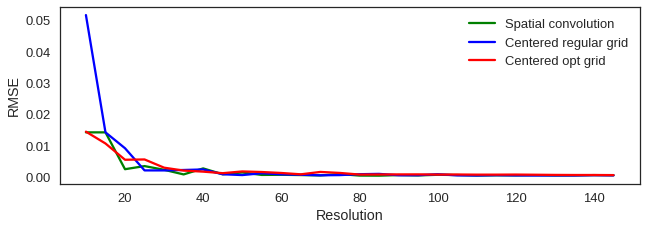

In [17]:
resolution_list = np.arange(10,150,5)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(resolution_list,rmse_reg_loop_list,'g',label = 'Spatial convolution')
ax.plot(resolution_list,rmse_reg_list,'b',label = 'Centered regular grid')
ax.plot(resolution_list,rmse_ml_list,'r', label = 'Centered opt grid')
# ax.set_yscale('log')
# ax.set_ylim(0,2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('Resolution')
plt.legend()

In [22]:
import matplotlib.patches as patches
def plot_(Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,
          grav_regular,grav_center_reg,grav_center_ML,rmse_center_reg = None,rmse_center_ml=None,rmse_covolution=None,resolution_list = None,i = None):
  # fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (20,5),sharex=True)

  fig = plt.figure(figsize=(15,8))
  ax1 = fig.add_subplot(3, 1, 1)
  ax2 = fig.add_subplot(3, 1, 2) 
  if rmse_center_reg is not None:
    ax4 = fig.add_subplot(3,1,3)
  ax1.plot(x_obs,-grav_analytical_full,'--',label ='analytical')

  circle1 = plt.Circle((sphere_position[0], sphere_position[2]+5), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)

  ax1.plot(receivers[:,0],-grav_regular,'g.',label = 'convoloted regular grid') # convoluted regular grid
  ax1.plot(receivers[:,0],-grav_center_reg,'b.',label = 'kernel reguar grid') # contered regular grid
  ax1.plot(receivers[:,0], -grav_center_ML,'r.', label = 'kernel optimized grid')
  ax1.axhline(y = 0,xmin = 0, xmax = 1000,c = 'k',ls = '--',alpha = 0.4)
  # ax1.set_ylim(-0.1,0.3)
  ax1.set_xlim(0,10000)
  ax1.set_ylabel('$mgal$')
  ax1.legend()

  ax2.set_aspect('equal')  
  ax2.add_patch(patches.Rectangle((0, 0),10000,1000,edgecolor = '#5bbbd3',facecolor =(0.35686,0.73333,0.82745,0.1),fill=True)) # padding area
  ax2.add_patch(patches.Rectangle((2000, 0),6000,1000,edgecolor = 'black',facecolor =(0.58039,0.83137,0.61176,0.2),fill=True)) # modelling area
  ax2.add_patch(patches.Rectangle((3000, 0),4000,1000,edgecolor = 'black',facecolor =(0.97255,0.96863,0.49020,0.2),fill=True)) # window 


  ax2.add_patch(circle1)
  Z_x_tensor = Z_x.reshape(regular_grid_resolution)
  ax2.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax2.set_xlabel('x', fontsize=16,fontname="Times New Roman")
  ax2.set_ylabel('z', fontsize=16,fontname="Times New Roman")
  ax2.scatter(model.receivers[:,0],1000*np.ones(model.receivers[:,0].shape),marker='v')



  circle1 = plt.Circle((sphere_position[0], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)

  if rmse_center_reg is not None:
    ax4.plot(resolution_list[:i],rmse_covolution[:i],'g',label = 'Spatial convolution')
    ax4.plot(resolution_list[:i],rmse_center_reg[:i],'b',label='Centered Regular grid')
    ax4.plot(resolution_list[:i],rmse_center_ml[:i],'r',label = 'Centered optimized grid')
    # ax4.set_ylim(-0.005,0.75)
    ax4.set_xlim(resolution_list[0],resolution_list[-1])
    ax4.set_ylabel('RMSE',rotation = 90,fontweight="bold",labelpad=0)
    ax4.yaxis.set_label_position("left")
    ax4.set_xlabel('Resolution ($xy$)')
    # ax4.set_yscale('log')
    # ax4.yaxis.set_tick_params(rotation=90)
    ax4.yaxis.tick_left()
    ax4.legend()

cell size is : [27.5862069 27.5862069 50.       ]


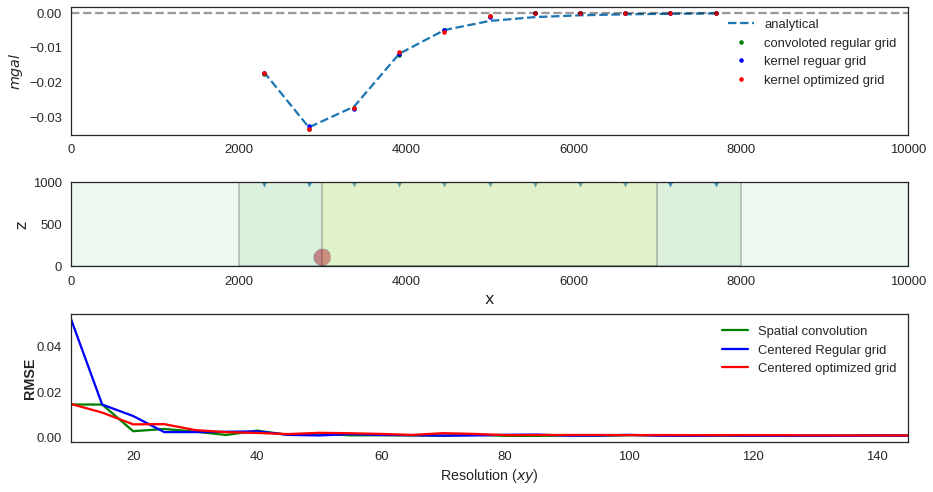

In [24]:
regular_grid_resolution = c2r(model_radius,center_grid_resolution,extent).tolist()
x_obs = model.receivers[:,0]
plot_(full_Z_x.numpy(), 
      regular_grid_resolution,
      sphere_radius,
      model.sphere_position,
      x_obs,
      model.grav_analytical_obs,
      grav_all_loop.numpy(),
      grav_regular_center,
      grav_ML_center,
      rmse_center_reg = rmse_reg_list,
      rmse_center_ml=rmse_ml_list,
      rmse_covolution = rmse_reg_loop_list,
      resolution_list = resolution_list,
      i = len(resolution_list)) 
plt.savefig('/content/drive/MyDrive/YJ/Gravity_valid/Figures/100_sphere_1streview_reverse.png',dpi = 300)

In [25]:
import matplotlib.patches as patches
def plot_(Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,
          grav_regular,grav_center_reg,grav_center_ML,rmse_center_reg = None,rmse_center_ml=None,rmse_covolution=None,resolution_list = None,i = None):
  # fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (20,5),sharex=True)

  fig = plt.figure(figsize=(23,8))
  ax1 = fig.add_subplot(3, 6, (1, 9))
  ax2 = fig.add_subplot(3, 6, (13, 15)) 
  ax3 = fig.add_subplot(1, 6, 4)
  if rmse_center_reg is not None:
    ax4 = fig.add_subplot(1, 6, (5,6))
  ax1.plot(x_obs,-grav_analytical_full)

  circle1 = plt.Circle((sphere_position[0], sphere_position[2]+5), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)

  ax1.plot(receivers[:,0],-grav_regular,'g.',label = 'convoloted regular grid') # convoluted regular grid
  ax1.plot(receivers[:,0],-grav_center_reg,'b.',label = 'center reguar grid') # contered regular grid
  ax1.plot(receivers[:,0], -grav_center_ML,'r.', label = 'center ML grid')
  ax1.axhline(y = 0,xmin = 0, xmax = 1000,c = 'k',ls = '--',alpha = 0.4)
  ax1.set_ylim(-0.1,0.3)
  ax1.set_xlim(0,10000)
  ax1.set_ylabel('$mgal$')
  ax1.legend()

  ax2.set_aspect('equal')  
  ax2.add_patch(patches.Rectangle((0, 0),10000,1000,edgecolor = '#5bbbd3',facecolor =(0.35686,0.73333,0.82745,0.1),fill=True)) # padding area
  ax2.add_patch(patches.Rectangle((2000, 0),6000,1000,edgecolor = 'black',facecolor =(0.58039,0.83137,0.61176,0.2),fill=True)) # modelling area
  ax2.add_patch(patches.Rectangle((3000, 0),4000,1000,edgecolor = 'black',facecolor =(0.97255,0.96863,0.49020,0.2),fill=True)) # window 


  ax2.add_patch(circle1)
  Z_x_tensor = Z_x.reshape(regular_grid_resolution)
  ax2.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax2.set_xlabel('x', fontsize=16,fontname="Times New Roman")
  ax2.set_ylabel('z', fontsize=16,fontname="Times New Roman")



  circle1 = plt.Circle((sphere_position[0], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)
  ax3.add_patch(circle1)
  ax3.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax3.set_xlim(sphere_position[0]-200,sphere_position[0]+200)
  ax3.set_aspect('equal') 
  ax3.yaxis.set_tick_params(rotation=90)
  # ax3.yaxis.tick_right()
  # plt.tight_layout()

  if rmse_center_reg is not None:
    ax4.plot(resolution_list[:i],rmse_covolution[:i],'g',label = 'Spatial convolution')
    ax4.plot(resolution_list[:i],rmse_center_reg[:i],'b',label='Centered Regular grid')
    ax4.plot(resolution_list[:i],rmse_center_ml[:i],'r',label = 'Centered optimized grid')
    ax4.set_ylim(-0.005,1.0)
    ax4.set_xlim(resolution_list[0],resolution_list[-1])
    ax4.set_ylabel('RMSE',rotation = 270,fontweight="bold",labelpad=10)
    ax4.yaxis.set_label_position("right")
    ax4.set_xlabel('Resolution ($xy$)')
    # ax4.yaxis.set_tick_params(rotation=90)
    ax4.yaxis.tick_right()
    ax4.legend()

  ax1.set_ylim(-2.1, .2)




cell size is : [27.5862069 27.5862069 50.       ]


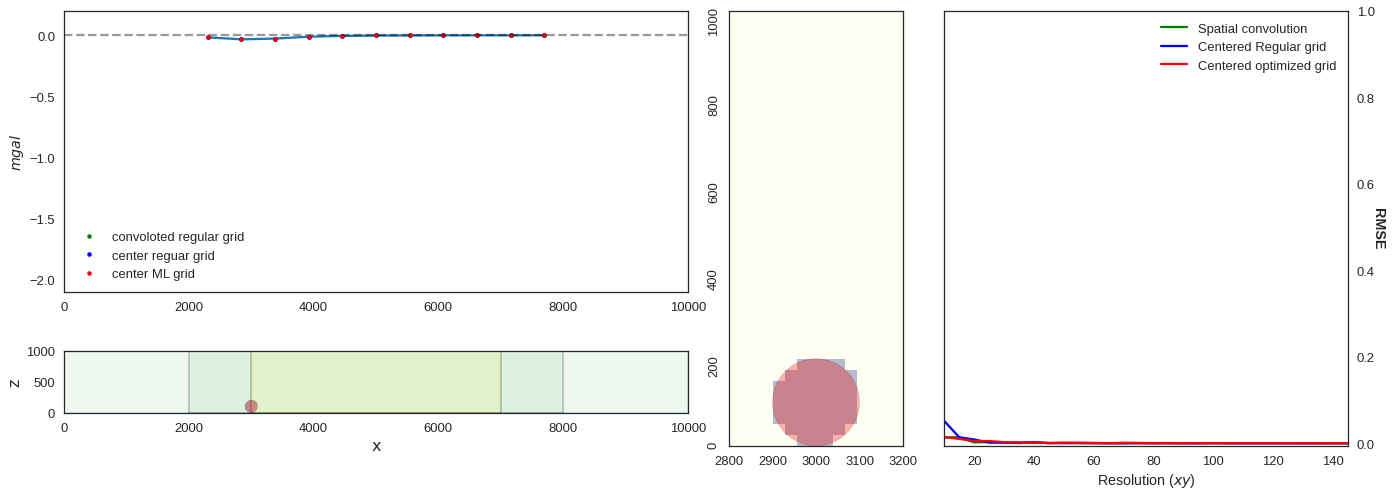

In [26]:
regular_grid_resolution = c2r(model_radius,center_grid_resolution,extent).tolist()
plot_(full_Z_x.numpy(), 
      regular_grid_resolution,
      sphere_radius,
      model.sphere_position,
      x_obs,
      model.grav_analytical_obs,
      grav_all_loop.numpy(),
      grav_regular_center,
      grav_ML_center,
      rmse_center_reg = rmse_reg_list,
      rmse_center_ml=rmse_ml_list,
      rmse_covolution = rmse_reg_loop_list,
      resolution_list = resolution_list,
      i = len(resolution_list)) 

In [ ]:
import imageio

In [ ]:
filenames = []

for i in range(len(resolution_list)):
  n = resolution_list[i]
  center_grid_resolution = [n,n,40]
  regular_grid_resolution = c2r(model_radius,center_grid_resolution,extent).tolist()
  plot_(full_zx_list[i].numpy(), 
        regular_grid_resolution,
        sphere_radius,
        model.sphere_position,
        x_obs,
        model.grav_analytical_obs,
        grav_cov_list[i].numpy(),
        grav_center_reg_list[i].numpy(),
        grav_center_ML_list[i].numpy(),
        rmse_center_reg = rmse_reg_list,
        rmse_center_ml=rmse_ml_list,
        rmse_covolution = rmse_reg_loop_list,
        resolution_list = resolution_list,
        i = i ) 
  
  filename = f'{n}.png'
  filenames.append(filename)

  plt.savefig(filename,
   bbox_inches='tight')
  plt.close()

# build gif
with imageio.get_writer('/content/drive/MyDrive/YJ/Gravity_valid/mygif{}_1streview.gif'.format(int(model.sphere_position[-1])), mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)

cell size is : [363.63636364 363.63636364  50.        ]
cell size is : [266.66666667 266.66666667  50.        ]
cell size is : [190.47619048 190.47619048  50.        ]
cell size is : [160. 160.  50.]
cell size is : [129.03225806 129.03225806  50.        ]
cell size is : [114.28571429 114.28571429  50.        ]
cell size is : [97.56097561 97.56097561 50.        ]
cell size is : [88.88888889 88.88888889 50.        ]
cell size is : [78.43137255 78.43137255 50.        ]
cell size is : [72.72727273 72.72727273 50.        ]
cell size is : [65.57377049 65.57377049 50.        ]
cell size is : [61.53846154 61.53846154 50.        ]
cell size is : [56.33802817 56.33802817 50.        ]
cell size is : [53.33333333 53.33333333 50.        ]
cell size is : [49.38271605 49.38271605 50.        ]
cell size is : [47.05882353 47.05882353 50.        ]
cell size is : [43.95604396 43.95604396 50.        ]
cell size is : [42.10526316 42.10526316 50.        ]
cell size is : [39.6039604 39.6039604 50.       ]
ce

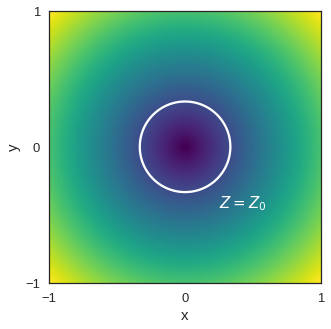

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

x = np.linspace(-3,3,100)
xv, yv = np.meshgrid(x, x)
r = np.sqrt((xv)**2 + (yv)**2)
# com = ndimage.measurements.center_of_mass(norm2d)
plt.contour(r,levels =[1],extent=[-1,1,-1,1],colors = 'white')
plt.imshow(r, origin="lower",cmap='viridis',extent=[-1,1,-1,1])
plt.text(0.25, -0.45, r'$Z = Z_0$', dict(size=15),c = 'w')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.xlabel('x',fontsize = 15)
plt.ylabel('y',fontsize = 15)
plt.gca().set_xticks([-1,0,1])
plt.gca().set_yticks([-1,0,1])

# plt.savefig('/content/drive/MyDrive/YJ/Gravity_valid/Figures/scalar_sphere.png',dpi = 500,bbox_inches='tight')